In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Pfad zum Projekt-Root hinzufügen, um das Package 'src' zu finden
# Annahme: Dieses Notebook liegt in src/notebooks/
import sys
from pathlib import Path

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm



In [2]:
# custom imports
PROJECT_ROOT = Path(__file__).resolve().parent.parent.parent if "__file__" in locals() else Path("../../..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.d_eval.evaluation.loader import load_model, load_test_data_v2
from src.d_eval.evaluation.style import apply_shap_style, get_model_style, save_plot, SHAP_RED, SHAP_BLUE

apply_shap_style()

In [3]:
# paths
DATA_DIR = "/Users/robin/PycharmProjects/Masterarbeit_Public/data/parquet/features/asinh1-reg"
VAL_SET_PATH = DATA_DIR + "/splits/val_purged.parquet"
SCALER_PATH = DATA_DIR + "/scaler/scaler.joblib"
MODEL_PATH = "/Users/robin/PycharmProjects/Masterarbeit_Public/models/EBM.joblib"

# figures
FIGURES_DIR = "figures/ebm"

# target
TARGET_COL = "label_5min"
THINNING_FREQ_MIN = 5

In [4]:
# load model
model = load_model(MODEL_PATH)

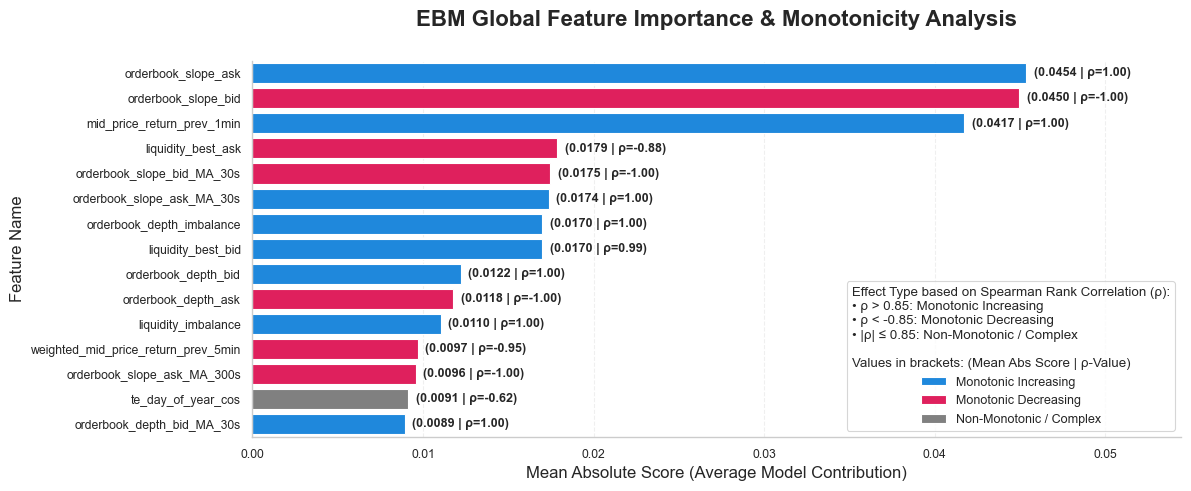

✅ Grafik gespeichert in: figures/ebm/ebm_feature_importance_top_10


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr


def plot_ebm_feature_importance_analysis(ebm_model, top_n=50, save_name=None):
    """
    Plots EBM feature importance with color-coded monotonicity based on Spearman Rho.
    """
    ebm_global = ebm_model.explain_global()
    global_data = ebm_global.data()

    features = []

    for i in range(len(global_data['names'])):
        f_name = global_data['names'][i]
        f_importance = global_data['scores'][i]

        # Calculate Monotonicity via Spearman Correlation on the shape data
        shape_data = ebm_global.data(i)
        scores = np.array(shape_data['scores'])

        if len(scores) > 1:
            # We correlate bin order (0, 1, 2...) with the score values
            rho, _ = spearmanr(np.arange(len(scores)), scores)
        else:
            rho = 0

        features.append({
            'Feature': f_name,
            'Importance': f_importance,
            'Spearman_Rho': rho
        })

    df = pd.DataFrame(features).sort_values(by='Importance', ascending=False).head(top_n)

    # Categorization logic
    def categorize_effect(rho):
        if rho > 0.85: return 'Monotonic Increasing'
        if rho < -0.85: return 'Monotonic Decreasing'
        return 'Non-Monotonic / Complex'

    df['Effect Type'] = df['Spearman_Rho'].apply(categorize_effect)

    # Visualization
    fig = plt.figure(figsize=(12, len(df) * 0.2 + 2))
    sns.set_context("paper")

    color_map = {
        'Monotonic Increasing': SHAP_BLUE,  # Green
        'Monotonic Decreasing': SHAP_RED,  # Red
        'Non-Monotonic / Complex': "gray"  # Blue
    }

    ax = sns.barplot(
        data=df,
        x='Importance',
        y='Feature',
        hue='Effect Type',
        palette=color_map,
        dodge=False
    )

    # Formatting Title and Labels
    plt.title("EBM Global Feature Importance & Monotonicity Analysis", fontsize=16, fontweight='bold', pad=25)
    plt.xlabel("Mean Absolute Score (Average Model Contribution)", fontsize=12)
    plt.ylabel("Feature Name", fontsize=12)

    # Enhanced Legend with Methodological Note
    legend_text = (
        "Effect Type based on Spearman Rank Correlation (ρ):\n"
        "• ρ > 0.85: Monotonic Increasing\n"
        "• ρ < -0.85: Monotonic Decreasing\n"
        "• |ρ| ≤ 0.85: Non-Monotonic / Complex\n\n"
        "Values in brackets: (Mean Abs Score | ρ-Value)"
    )
    plt.legend(title=legend_text, loc='lower right', bbox_to_anchor=(1, 0), fontsize=9)

    # Value Labels
    max_val = df['Importance'].max()
    for i, (v, r) in enumerate(zip(df['Importance'], df['Spearman_Rho'])):
        plt.text(v + (max_val * 0.01), i, f"({v:.4f} | ρ={r:.2f})", va='center', fontsize=9, fontweight='bold')

    # xlim
    plt.xlim(0, max_val * 1.2)

    plt.grid(axis='x', linestyle='--', alpha=0.3)
    sns.despine()
    plt.tight_layout()
    plt.show()

    if save_name:
        save_plot(fig, save_name, FIGURES_DIR)

    return df


# Execution
analysis_df = plot_ebm_feature_importance_analysis(model, top_n=15, save_name="ebm_feature_importance_top_10")

In [6]:
from interpret import show

# Zeigt ein Dashboard mit allen Features und der Importance an
show(model.explain_global())

<!-- http://127.0.0.1:7001/6033042336/ -->

In [7]:
def get_ebm_importance(ebm_model, top_n=50, title="Feature Importance (Mean Absolute Score)"):
    """
    Extrahiert die globale Wichtigkeit aus einem EBM und erstellt einen
    hochwertigen Barplot für die Masterarbeit.
    """
    # 1. Daten aus dem EBM-Objekt extrahieren
    ebm_global = ebm_model.explain_global()
    global_data = ebm_global.data()

    # 2. DataFrame erstellen und sortieren
    importance_df = pd.DataFrame({
        'Feature': global_data['names'],
        'Importance': global_data['scores']
    }).sort_values(by='Importance', ascending=False)

    return importance_df  # Gibt das DF zurück, falls du die Werte weiterverarbeiten willst


# Aufruf der Funktion:
importance_results = get_ebm_importance(model, top_n=77)

✅ Grafik gespeichert in: figures/ebm/ebm_top_35_shapes.png


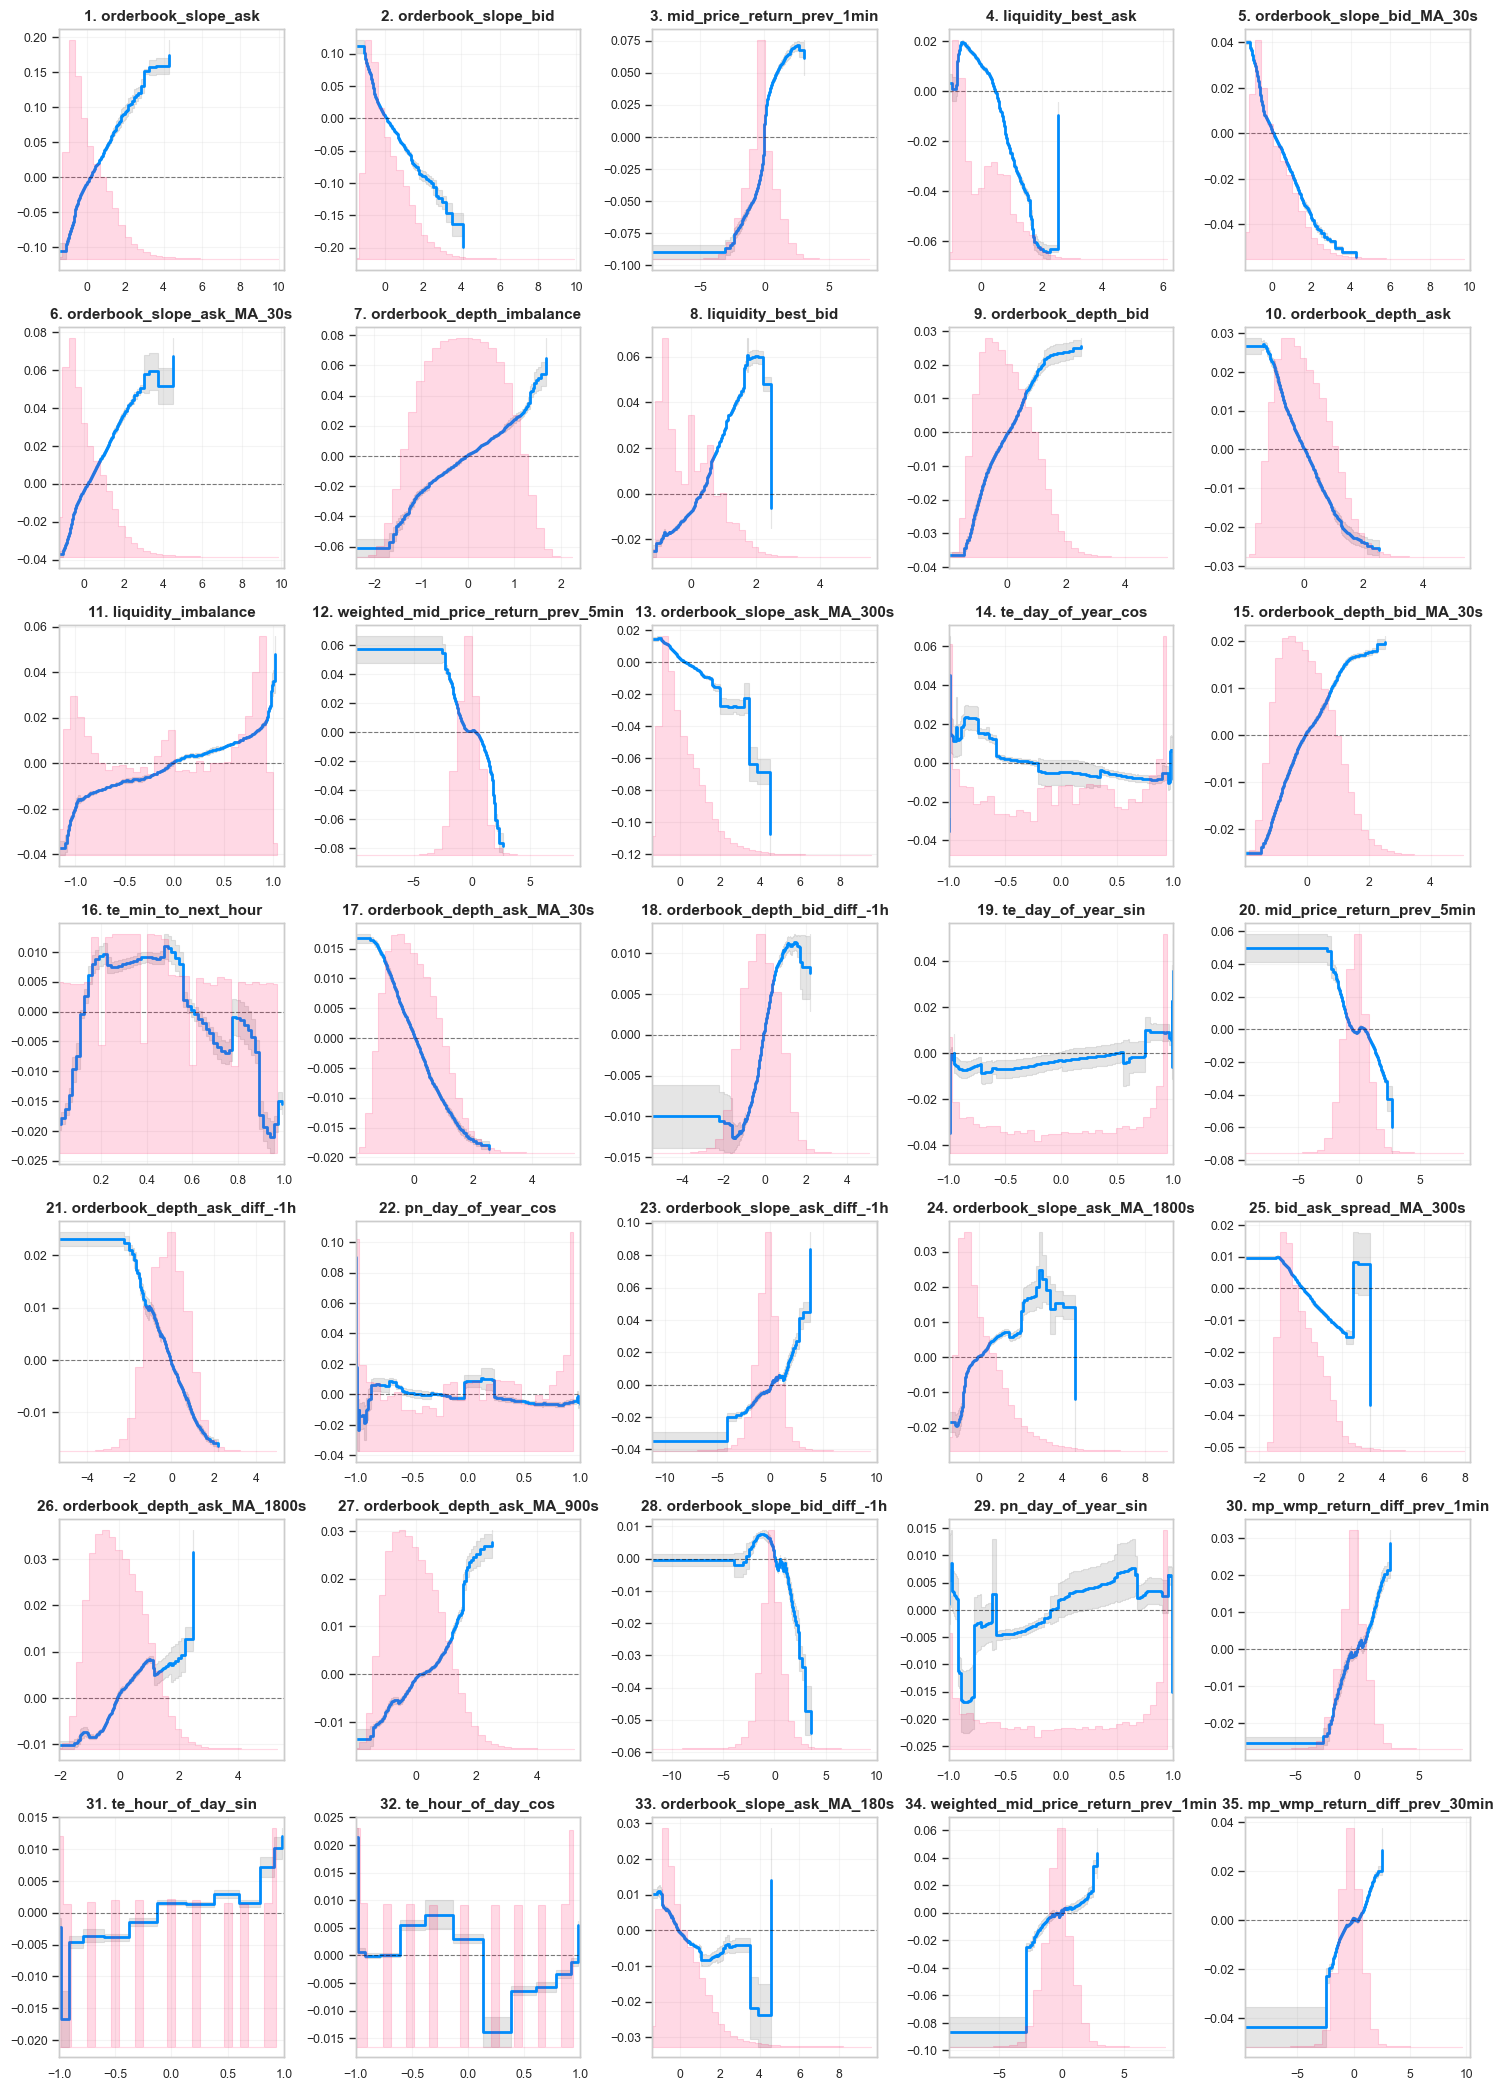

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_top_ebm_shapes_final_robust(ebm, importance_df, top_n=10, save_name=None):
    top_features = importance_df.head(top_n)
    cols = 5
    rows = int(np.ceil(top_n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()
    ebm_global = ebm.explain_global()

    for i, (idx, row) in enumerate(top_features.iterrows()):
        feature_name = row['Feature']
        ax = axes[i]
        try:
            feat_idx = ebm_global.feature_names.index(feature_name)
            data = ebm_global.data(feat_idx)

            # 1. Score-Daten extrahieren
            s_names = np.array(data['names'])
            s_scores = np.array(data['scores'])
            s_lower = np.array(data['lower_bounds'])
            s_upper = np.array(data['upper_bounds'])

            # 2. Dichte-Daten extrahieren
            density_dict = data.get('density', {})
            d_names = np.array(density_dict.get('names', []))
            d_scores = np.array(density_dict.get('scores', []))

            # Prüfung auf Numerik
            try:
                x_centers = s_names.astype(float)
                is_numeric = True
            except:
                is_numeric = False

            if is_numeric:
                # Gemeinsame Limits bestimmen
                x_min = min(x_centers.min(), d_names.min() if len(d_names) > 0 else x_centers.min())
                x_max = max(x_centers.max(), d_names.max() if len(d_names) > 0 else x_centers.max())

                # --- Histogramm (Hintergrund) ---
                if len(d_names) > 0 and len(d_scores) > 0:
                    ax_hist = ax.twinx()
                    # Wir nutzen d_names und d_scores direkt - Matplotlib regelt das x/y Pairing
                    # 'min_len' sorgt dafür, dass innerhalb des Dichte-Objekts kein Mismatch herrscht
                    d_len = min(len(d_names), len(d_scores))
                    ax_hist.fill_between(d_names[:d_len], 0, d_scores[:d_len],
                                         color=SHAP_RED, alpha=0.15, step='mid')
                    ax_hist.set_yticks([])
                    ax_hist.set_xlim(x_min, x_max)  # Hard-Sync der X-Achse

                # --- Score Plot (Vordergrund) ---
                # Auch hier: min_len für Score-Daten
                s_len = min(len(x_centers), len(s_scores), len(s_lower), len(s_upper))
                ax.step(x_centers[:s_len], s_scores[:s_len], where='post', color=SHAP_BLUE, linewidth=2)
                ax.fill_between(x_centers[:s_len], s_lower[:s_len], s_upper[:s_len],
                                step='post', alpha=0.2, color='gray')
                ax.set_xlim(x_min, x_max)  # Hard-Sync der X-Achse

            else:
                # Kategorialer Fall
                x_pos = np.arange(len(s_names))
                ax.bar(x_pos, s_scores[:len(s_names)], color='#1f77b4', alpha=0.7)
                ax.set_xticks(x_pos)
                ax.set_xticklabels(s_names, rotation=45, ha='right')

            ax.set_title(f"{i + 1}. {feature_name}", fontsize=11, fontweight='bold')
            ax.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
            ax.grid(alpha=0.2)
            ax.patch.set_visible(False)

        except Exception as e:
            print(f"Fehler bei {feature_name}: {e}")

    for j in range(i + 1, len(axes)): axes[j].axis('off')
    plt.tight_layout()

    if save_name:
        save_plot(fig, save_name, FIGURES_DIR)

    plt.show()


top_n = 35
plot_top_ebm_shapes_final_robust(model, importance_results, top_n=top_n, save_name=f"ebm_top_{top_n}_shapes.png")